In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from copy import deepcopy

import scipy
from scipy import special as s
import pandas as pd
import numpy
import math
from time import time

/Users/karlhajjar/Documents/projects/deep-wide-resnets/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks.resnet import ResNet

# Constants

In [6]:
INPUT_DIM = 64 #30
WIDTH = 256 #128 # 512 #40 # 256
#D_MODEL = 128
N_RES = 500 # 1000 #1000
BIAS = False
ALPHA = 1.0
SCALE = 1.0
ACTIVATION = 'relu'

SEED = 42
N_SAMPLES = 50 #50
N_TRIALS = 10
BASE_LR = 1.0e-4

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/init/')
create_dir(FIGURES_DIR)

In [8]:
set_random_seeds(SEED)

In [9]:
(start, num) = (10, 10)
betas = [0.25, 0.5, 1.0] #[0., 0.25, 0.5, 1.0]
all_x = torch.randn(size=(N_TRIALS, N_SAMPLES, INPUT_DIM))
n_res_grid = np.linspace(start=start, stop=N_RES, num=10, dtype=int)

# Original init $\mathcal{U}(-\sqrt{3/d_{model}}, \sqrt{3/d_{model}})$

In [10]:
ratios = dict()
kind = 'reproduce'

s = time()
with torch.no_grad():
    for beta in betas:
        ratios_ = {n_res: [] for n_res in n_res_grid}
        
        for n_res in n_res_grid:
            for i in range(N_TRIALS):
                alpha = n_res**(-beta)
                net = ResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=BIAS, alpha=alpha, 
                             n_res=n_res, kind=kind) 
                x = all_x[i, :, :]
                
                h_0 = net.input_layer(x)
                h_L = net.residual_layers(h_0)
                ratios_[n_res].append(torch.mean(torch.norm(h_L - h_0, dim=1, p=2) / 
                                                 torch.norm(h_0, dim=1, p=2)).detach().item())

        ratios[beta] = ratios_
e = time()
print('Time for L={:,}, num={:,} and N_TRIALS={:,} : {:.2f} minutes'.format(N_RES, num, N_TRIALS, (e - s)/60))

Time for L=500, num=10 and N_TRIALS=10 : 3.41 minutes


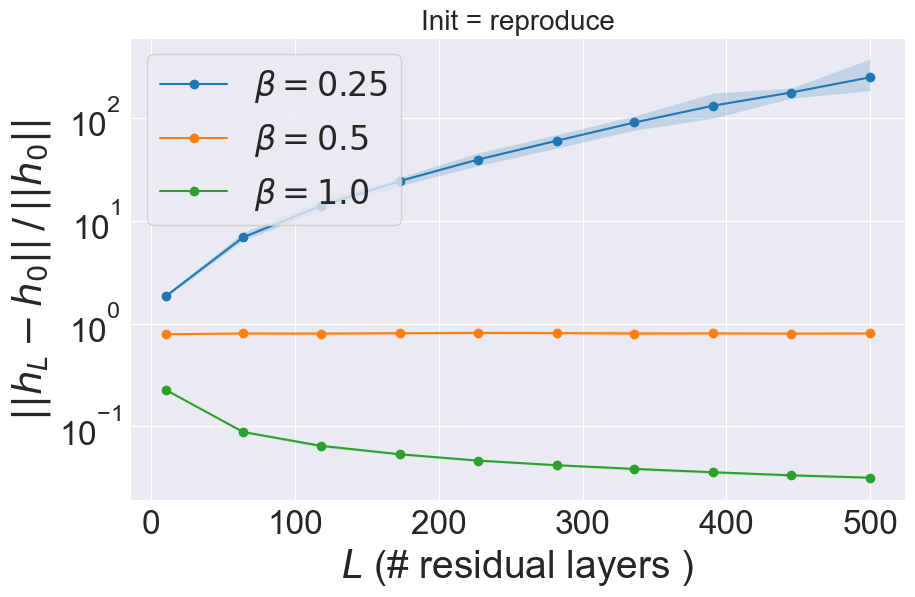

In [11]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
#plt.xscale('log')
colors = sns.color_palette()
for i, (key, value) in enumerate(ratios.items()):
    
    data = pd.DataFrame(value)
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values

    plt.plot(n_res_grid, means, marker='o', label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(n_res_grid, mins, maxs, alpha=0.2)

plt.xlabel('$L$ (# residual layers )', fontsize=28)
plt.ylabel('$||h_L - h_0 || \, / \, ||h_0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.title('Init = {}'.format(kind), fontsize=20)
#plt.savefig(os.path.join(FIGURES_DIR, '.png'))
plt.show()

# Glorot init

In [12]:
ratios = dict()
kind = 'glorot'

s = time()
with torch.no_grad():
    for beta in betas:
        ratios_ = {n_res: [] for n_res in n_res_grid}
        
        for n_res in n_res_grid:
            for i in range(N_TRIALS):
                alpha = n_res**(-beta)
                net = ResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=BIAS, alpha=alpha, 
                             n_res=n_res, kind=kind) 
                x = all_x[i, :, :]
                
                h_0 = net.input_layer(x)
                h_L = net.residual_layers(h_0)
                ratios_[n_res].append(torch.mean(torch.norm(h_L - h_0, dim=1, p=2) / 
                                                 torch.norm(h_0, dim=1, p=2)).detach().item())

        ratios[beta] = ratios_
e = time()
print('Time for L={:,}, num={:,} and N_TRIALS={:,} : {:.2f} minutes'.format(N_RES, num, N_TRIALS, (e - s)/60))

Time for L=500, num=10 and N_TRIALS=10 : 2.84 minutes


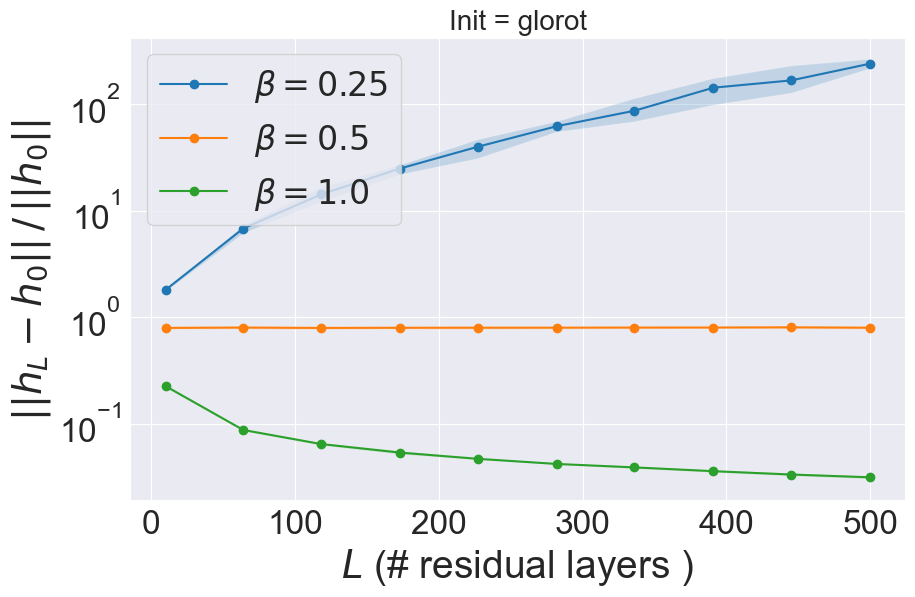

In [13]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
#plt.xscale('log')
colors = sns.color_palette()
for i, (key, value) in enumerate(ratios.items()):
    
    data = pd.DataFrame(value)
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values

    plt.plot(n_res_grid, means, marker='o', label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(n_res_grid, mins, maxs, alpha=0.2)

plt.xlabel('$L$ (# residual layers )', fontsize=28)
plt.ylabel('$||h_L - h_0 || \, / \, ||h_0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.title('Init = {}'.format(kind), fontsize=20)
#plt.savefig(os.path.join(FIGURES_DIR, '.png'))
plt.show()

# He-fan_in init

In [ ]:
ratios = dict()
kind = 'he'
mode = 'fan_in'

s = time()
with torch.no_grad():
    for beta in betas:
        ratios_ = {n_res: [] for n_res in n_res_grid}
        
        for n_res in n_res_grid:
            for i in range(N_TRIALS):
                alpha = n_res**(-beta)
                net = ResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=BIAS, alpha=alpha, 
                             n_res=n_res, kind=kind, mode=mode) 
                x = all_x[i, :, :]
                
                h_0 = net.input_layer(x)
                h_L = net.residual_layers(h_0)
                ratios_[n_res].append(torch.mean(torch.norm(h_L - h_0, dim=1, p=2) / 
                                                 torch.norm(h_0, dim=1, p=2)).detach().item())

        ratios[beta] = ratios_
e = time()
print('Time for L={:,}, num={:,} and N_TRIALS={:,} : {:.2f} minutes'.format(N_RES, num, N_TRIALS, (e - s)/60))

In [ ]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
#plt.xscale('log')
colors = sns.color_palette()
for i, (key, value) in enumerate(ratios.items()):
    
    data = pd.DataFrame(value)
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values

    plt.plot(n_res_grid, means, marker='o', label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(n_res_grid, mins, maxs, alpha=0.2)

plt.xlabel('$L$ (# residual layers )', fontsize=28)
plt.ylabel('$||h_L - h_0 || \, / \, ||h_0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.title('Init = {}-{}'.format(kind, mode), fontsize=20)
#plt.savefig(os.path.join(FIGURES_DIR, '.png'))
plt.show()

# He-fan_out init

In [ ]:
ratios = dict()
kind = 'he'
mode = 'fan_out'

s = time()
with torch.no_grad():
    for beta in betas:
        ratios_ = {n_res: [] for n_res in n_res_grid}
        
        for n_res in n_res_grid:
            for i in range(N_TRIALS):
                alpha = n_res**(-beta)
                net = ResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=BIAS, alpha=alpha, 
                             n_res=n_res, kind=kind, mode=mode) 
                x = all_x[i, :, :]
                
                h_0 = net.input_layer(x)
                h_L = net.residual_layers(h_0)
                ratios_[n_res].append(torch.mean(torch.norm(h_L - h_0, dim=1, p=2) / 
                                                 torch.norm(h_0, dim=1, p=2)).detach().item())

        ratios[beta] = ratios_
e = time()
print('Time for L={:,}, num={:,} and N_TRIALS={:,} : {:.2f} minutes'.format(N_RES, num, N_TRIALS, (e - s)/60))

In [ ]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
#plt.xscale('log')
colors = sns.color_palette()
for i, (key, value) in enumerate(ratios.items()):
    
    data = pd.DataFrame(value)
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values

    plt.plot(n_res_grid, means, marker='o', label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(n_res_grid, mins, maxs, alpha=0.2)

plt.xlabel('$L$ (# residual layers )', fontsize=28)
plt.ylabel('$||h_L - h_0 || \, / \, ||h_0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.title('Init = {}-{}'.format(kind, mode), fontsize=20)
#plt.savefig(os.path.join(FIGURES_DIR, '.png'))
plt.show()

# Gaussian 

In [ ]:
ratios = dict()
kind = 'gaussian'

s = time()
with torch.no_grad():
    for beta in betas:
        ratios_ = {n_res: [] for n_res in n_res_grid}
        
        for n_res in n_res_grid:
            for i in range(N_TRIALS):
                alpha = n_res**(-beta)
                net = ResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=BIAS, alpha=alpha, 
                             n_res=n_res, kind=kind) 
                x = all_x[i, :, :]
                
                h_0 = net.input_layer(x)
                h_L = net.residual_layers(h_0)
                ratios_[n_res].append(torch.mean(torch.norm(h_L - h_0, dim=1, p=2) / 
                                                 torch.norm(h_0, dim=1, p=2)).detach().item())

        ratios[beta] = ratios_
e = time()
print('Time for L={:,}, num={:,} and N_TRIALS={:,} : {:.2f} minutes'.format(N_RES, num, N_TRIALS, (e - s)/60))

In [ ]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
#plt.xscale('log')
colors = sns.color_palette()
for i, (key, value) in enumerate(ratios.items()):
    
    data = pd.DataFrame(value)
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values

    plt.plot(n_res_grid, means, marker='o', label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(n_res_grid, mins, maxs, alpha=0.2)

plt.xlabel('$L$ (# residual layers )', fontsize=28)
plt.ylabel('$||h_L - h_0 || \, / \, ||h_0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.title('Init = {}'.format(kind), fontsize=20)
#plt.savefig(os.path.join(FIGURES_DIR, '.png'))
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
#plt.xscale('log')
colors = sns.color_palette()
for i, (key, value) in enumerate(ratios.items()):
#    if key == 'Gaussian':
#        label = '$\\mathcal{N}(0, 1/d)$'
#    else:
#        label = key
    
    delta = 1 - 2 * key # \delta = 1 -2 \beta
    
    data = pd.DataFrame(value)
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values

    plt.plot(n_res_grid, means, marker='o', label='$\\beta = {}$'.format(key), c=colors[i])
    #plt.plot(n_residuals, means, label='$\\beta = {}$'.format(key))
    plt.fill_between(n_res_grid, mins, maxs, alpha=0.2)
    
    if delta > 0:
        #plt.plot(np.arange(start, N_RES), np.exp(np.arange(start, N_RES) ** delta), linestyle='dashed', c=colors[i], 
        #         label='$\\exp(L^{|\\delta|})$')
        plt.plot(np.arange(start, N_RES), np.exp(np.sqrt(np.arange(start, N_RES))) * np.exp(-1/2) - 1, 
                 linestyle='dashed', c=colors[i], label='$\\exp(L^{|\\delta|})$')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES), np.arange(start, N_RES) ** (delta), linestyle='dashed', c=colors[i], 
                 label='$L^{-|\\delta|}$')

plt.xlabel('$L$ (# residual layers )', fontsize=28)
plt.ylabel('$||h_L - h_0 || \, / \, ||h_0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, '.png'))
plt.show()